## Convolutional Networks

We'll check out how to build a **convolutional network** to classify CIFAR10 images. By using weight sharing - multiple units with the same weights - convolutional layers are able to learn repeated patterns in your data. For example, a unit could learn the pattern for an eye, or a face, or lower level features like edges.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import importlib
import os
import torch
from pathlib import Path
from shutil import copy
from torch import optim, nn
import torch.nn.functional as F
from socket import gethostname
import time

%matplotlib inline 
import matplotlib.pyplot as plt

from torchsummary import summary  # install with 'pip install torchsummary'
from tensorboardX import SummaryWriter

from utils import plot_images, get_train_valid_loader, plot_weights, plot_gradient_flow, read_json

In [2]:
# read config
filepath_config = 'configs/config.json'
CONFIG = read_json(filepath_config)

In [3]:
# import module
models = importlib.import_module('models')
ConvNet = getattr(models, CONFIG['parameters']['model'])
print('%s loaded' % CONFIG['parameters']['model'])

ConvNet_Type4 loaded


Files already downloaded and verified
Files already downloaded and verified


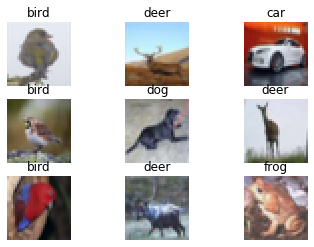

In [4]:
# get data loaders
trainloader, valloader = get_train_valid_loader()

In [5]:
# init net
net = ConvNet()

# plot net parameters
summary(net, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
            Conv2d-2           [-1, 32, 32, 32]          25,632
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
            Conv2d-5           [-1, 64, 16, 16]          36,928
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Linear-7                   [-1, 96]         393,312
            Linear-8                   [-1, 10]             970
Total params: 477,770
Trainable params: 477,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.84
Params size (MB): 1.82
Estimated Total Size (MB): 2.68
----------------------------------------------------------------


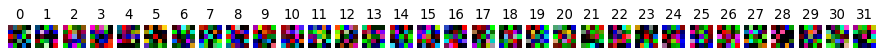

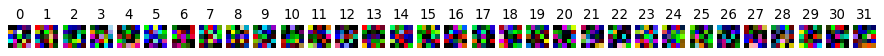

In [6]:
# visualize init weights
w = net.conv1.weight.data.numpy()
plot_weights(w,scaling=True)


--- EPOCH 001 / 003 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600


/Users/theo/anaconda3/envs/deep/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/theo/anaconda3/envs/deep/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Metrics: 
---> train loss / accuracy: 1.361 / 0.516
---> val loss / accuracy:   1.368 / 0.515
filters conv1


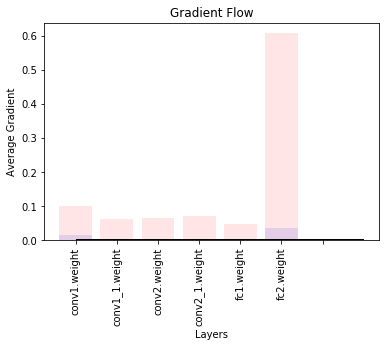

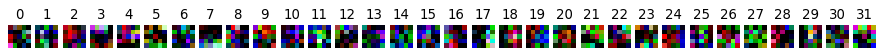

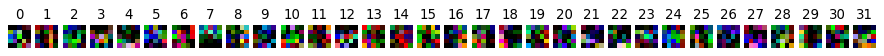

---> save new best checkpoint

--- EPOCH 002 / 003 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400
---> train on batch 600

Metrics: 
---> train loss / accuracy: 1.122 / 0.605
---> val loss / accuracy:   1.166 / 0.597
filters conv1


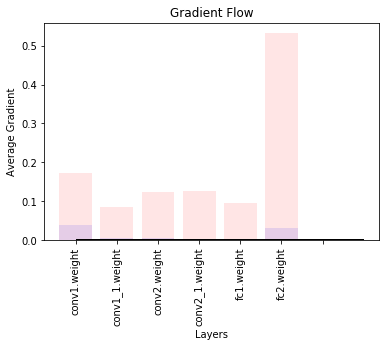

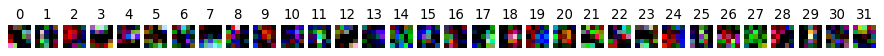

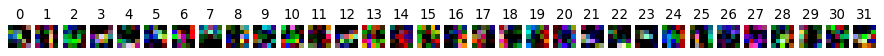

---> save new best checkpoint

--- EPOCH 003 / 003 STARTED ---
---> train on batch 000
---> train on batch 200
---> train on batch 400


KeyboardInterrupt: 

In [7]:
# create output directory
name_run = CONFIG['parameters']['model'] + '_' + gethostname() + '_' + '%d' % time.time()
filepath_run = os.path.join(CONFIG['parameters']['results'], name_run)
Path(filepath_run).mkdir(parents=True, exist_ok=True)

# copy models.py and config file for documentation
copy('models.py', os.path.join(filepath_run, 'models.py'))
copy(filepath_config, os.path.join(filepath_run, 'config.json'))

# set optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=CONFIG['parameters']['lr'], weight_decay=CONFIG['parameters']['l2_reg'])

# https://discuss.pytorch.org/t/how-to-do-exponential-learning-rate-decay-in-pytorch/63146/3
# https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, 
    factor=CONFIG['parameters']['lr_decay_rate'], 
    patience=CONFIG['parameters']['lr_decay_patience'], 
    threshold=CONFIG['parameters']['lr_decay_threshold'], 
    verbose = True)


epochs = CONFIG['parameters']['epochs']
running_loss = 0
print_every = 200
training_steps = 0

# init tensorboard writer
writer = SummaryWriter(log_dir=filepath_run)

val_acc_best = 0

for e in range(epochs):
    
    print('\n--- EPOCH %03d / %03d STARTED ---' % (e+1, epochs))
 
    # set net to train mode
    net.train()
    
    # log current learning rate
    writer.add_scalar('optimizer/learning_rate', optimizer.param_groups[0]['lr'], e+1)
    
    # train over all batches
    start = time.time()
    for idx_batch, (images, labels) in enumerate(trainloader):
        
        training_steps += 1
        
        if idx_batch % print_every == 0:
            print('---> train on batch %03d' % idx_batch)
        
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        
        optimizer.step()
        
        writer.add_scalar('train/loss_training_step', loss.item(), training_steps)
        
    # visualize gradients   
    plot_gradient_flow(net.named_parameters())

    # set net to evaluation mode
    net.eval()
    
    # evaluate on training data 
    train_loss_accum = 0.
    count_total = 0
    count_correct = 0
    for idx_batch, (images, labels) in enumerate(trainloader):
        output = net(images)
        loss = criterion(output, labels)
        train_loss_accum += loss.item()
        
        prediction = torch.argmax(F.softmax(output), axis=1)
        count_total += prediction.size(0)
        count_correct += (prediction == labels).sum().item()
        
    train_loss_avg = train_loss_accum / (idx_batch+1)
    train_acc = count_correct / count_total
    writer.add_scalar('train/loss_epoch', train_loss_avg, e+1)
    writer.add_scalar('train/accuracy', train_acc, e+1)
    
    # evaluate on validation data 
    val_loss_accum = 0.
    count_total = 0
    count_correct = 0
    for idx_batch, (images, labels) in enumerate(valloader):
        output = net(images)
        loss = criterion(output, labels)
        val_loss_accum += loss.item()
        
        prediction = torch.argmax(F.softmax(output), axis=1)
        count_total += prediction.size(0)
        count_correct += (prediction == labels).sum().item()

    val_loss_avg = val_loss_accum / (idx_batch+1)
    val_acc = count_correct / count_total
    writer.add_scalar('val/loss_epoch', val_loss_avg, e+1)
    writer.add_scalar('val/accuracy', val_acc, e+1)
    
    writer.add_scalar('val/train_val_loss_ratio', val_loss_avg-train_loss_avg, e+1)
    
    print('\nMetrics: ')
    print('---> train loss / accuracy: %.03f / %.03f' % (train_loss_avg, train_acc))
    print('---> val loss / accuracy:   %.03f / %.03f' % (val_loss_avg, val_acc))
    
    scheduler.step(val_loss_avg)
    
    print('filters conv1')
    w1 = net.conv1.weight.data.numpy()
    plot_weights(w1, scaling=True)
    plt.show()
    
    if val_acc > val_acc_best:
        val_acc_best = val_acc
        print('---> save new best checkpoint')
        filepath_ckpt = os.path.join(filepath_run, '%s_epoch-%03d_train-%.03f_val-%.03f.ckpt' % (CONFIG['parameters']['model'],e+1,train_acc,val_acc))
        torch.save(net.state_dict(), filepath_ckpt)

# close tensorboard logging
writer.close()

Save best trained model.